In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
%matplotlib inline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Data Prep

In [23]:
FNIEVES = pd.read_csv('Data/FNIEVES.csv')
CFJSANCHEZ = pd.read_csv('Data/CFJSANCHEZ2.csv')
DPICHAR = pd.read_csv('Data/DPICHAR.csv').drop(columns={'VOL/WEIGHT','MEASURE'})
FPEREZ_1 = pd.read_csv('Data/FPEREZ_1.csv')
FPEREZ_2 = pd.read_csv('Data/FPEREZ_2.csv')

In [24]:
df = pd.concat([FNIEVES,CFJSANCHEZ,DPICHAR,FPEREZ_1,FPEREZ_2], axis=0)
#df.to_csv('Data/comparefoods_combined.csv')

In [25]:
df.describe()

,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,DEPT#
count,3882486.00000,3882486.00000,3882486.00000,3882486.00000
mean,25.71476,44.12375,162.16696,1.45462
std,590.58551,185.54323,75.04430,1.03743
min,-20.00000,-1990.00000,100.00000,1.00000
25%,2.00000,4.38000,110.00000,1.00000
50%,4.00000,10.14000,150.00000,1.00000
75%,9.00000,27.90000,192.00000,2.00000
max,144492.00000,15561.98000,10006.00000,14.00000


In [26]:
df.tail()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT#,DEPT NAME,STORE NAME,STORE STATE
313085,2/20/2021,9.55644E+11,COCON,COCON GRAPE PUDDING,4.00000,12.76000,192.00000,INTERNATIONAL GROCERY,1.00000,GROCERY DEPT,FPEREZ,NC
313086,2/20/2021,1.75968E+12,CASSABITO,CASABITO YUCA CRACKERS NATURAL,2.00000,12.58000,192.00000,INTERNATIONAL GROCERY,1.00000,GROCERY DEPT,FPEREZ,NC
313087,2/20/2021,8.18374E+12,OCEANIC,OCEANIC FRESH WATER SHRIMPS HEAD ON CLAW ON,1.00000,24.99000,250.00000,FROZEN SEAFOOD,3.00000,MEAT DEPT,FPEREZ,NC
313088,2/20/2021,8.56414E+12,MORNING FRESH FARMS,MORNING FRESH FARMS WATER DRINKING .5 LT,15.00000,59.85000,100.00000,GROCERY DEPARTMENT,1.00000,GROCERY DEPT,FPEREZ,NC
313089,2/20/2021,8.68116E+12,AMORAY,AMORAY TOILET BOWL FRESH TOILET BOWL DEODERIZE...,1.00000,0.69000,195.00000,INTERNATIONAL NON FOOD GROCERY,1.00000,GROCERY DEPT,FPEREZ,NC


In [27]:
# Avoid Negative Values
cols = ['TotalUnits_F64','Total_Dollars_F65']
df[cols] = df[df[cols] > 0][cols]
df = df.dropna()

# Calculate Price
df['PRICE'] = df['Total_Dollars_F65']/df['TotalUnits_F64']


df = df.drop(columns=['UPC_F01'])


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3832959 entries, 0 to 313089
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DATES              datetime64[ns]
 1   BRAND              object        
 2   DESCRIPTION        object        
 3   TotalUnits_F64     float64       
 4   Total_Dollars_F65  float64       
 5   SUB DPT #          float64       
 6   SUB DPT            object        
 7   DEPT#              float64       
 8   DEPT NAME          object        
 9   STORE NAME         object        
 10  STORE STATE        object        
 11  PRICE              float64       
 12  YEAR               int64         
 13  MONTH              int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(6)
memory usage: 438.6+ MB


# 1. Price Elasticity of Demand 

In [29]:
def trim_outliers(df, col_name):
    average = df[col_name].mean()
    std=df[col_name].std()
    outliers= (df[col_name] - average).abs() > std
    df[outliers]= np.nan
    df[col_name]= df[col_name].fillna(average)
    return df

def elasticity_generator(df, dpt_col='DEPT NAME', dpt_unique=None):
    elasticity_calcs=pd.DataFrame([])
    filtered_df=df.fillna(0)
    filtered_df = trim_outliers(filtered_df,'PRICE')
    filtered_df = trim_outliers(filtered_df,'TotalUnits_F64')
    
    
    for dpt in departments:
        tmp_df=pd.DataFrame([])

        filtered_df= df[df[dpt_col]==dpt]
        filtered_df.head()

        y = np.log(filtered_df['TotalUnits_F64'])
        X = np.log(filtered_df['PRICE'])
        # Train
        slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
        tmp_df[dpt_col]=[dpt]
        tmp_df['intersept']=intercept
        tmp_df['coef']= slope
        tmp_df['R2']= r_value
        tmp_df['p_value']=p_value
        tmp_df['std_err']=std_err
        tmp_df['max']=filtered_df['TotalUnits_F64'].max()
        
        elasticity_calcs=pd.concat([elasticity_calcs, tmp_df], axis=0)
        
    return elasticity_calcs

In [30]:
agg_func_count = {'TotalUnits_F64': 'mean', 'Total_Dollars_F65': 'sum', 'PRICE':'mean', 'DEPT#':'first'}


### 2. Elasticity by Sub Department

In [10]:
sub_dpt_df = df.groupby(['DATES','SUB DPT']).agg(agg_func_count).reset_index()
departments = sub_dpt_df['SUB DPT'].unique()
elasticity_calcs = elasticity_generator(sub_dpt_df, dpt_col='SUB DPT', dpt_unique=departments)
elasticity_p = elasticity_calcs.sort_values(by=['coef', 'R2'], ascending=False).query("coef!=0 and p_value<0.05")

In [33]:
len(elasticity_p)

43

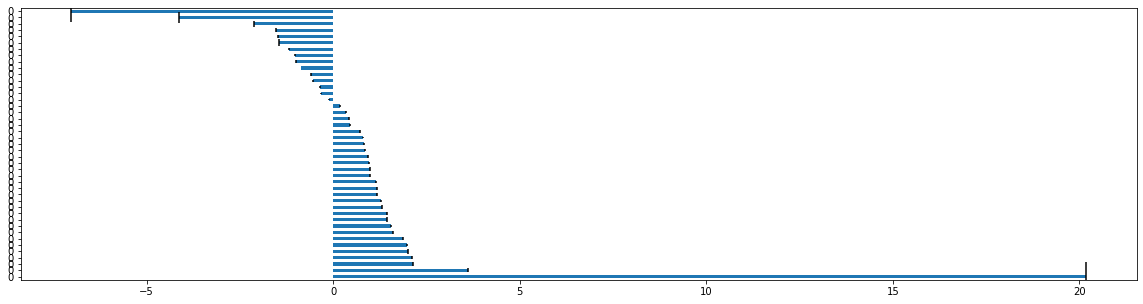

In [12]:
fig, ax = plt.subplots()

elasticity_p['coef'].plot(yerr=elasticity_p['std_err'], ax=ax, kind='barh',figsize=(20,5))

In [13]:
elasticity_p.to_csv('subdpt_elasticity.csv')

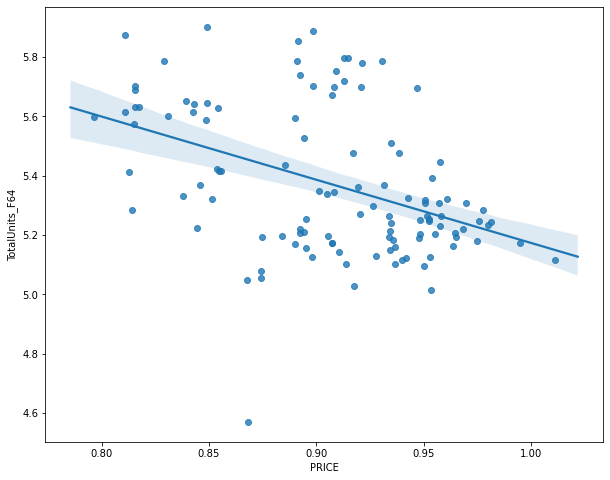

In [21]:
plt.subplots(figsize=(10,8))
plot_Df = sub_dpt_df[sub_dpt_df['SUB DPT']=='VEGETABLES DEPARTMENT']
sns.regplot(np.log(plot_Df['PRICE']),np.log(plot_Df['TotalUnits_F64']))

# 2. WordCloud

In [12]:
from wordcloud import WordCloud

### 1.  SubDepartment

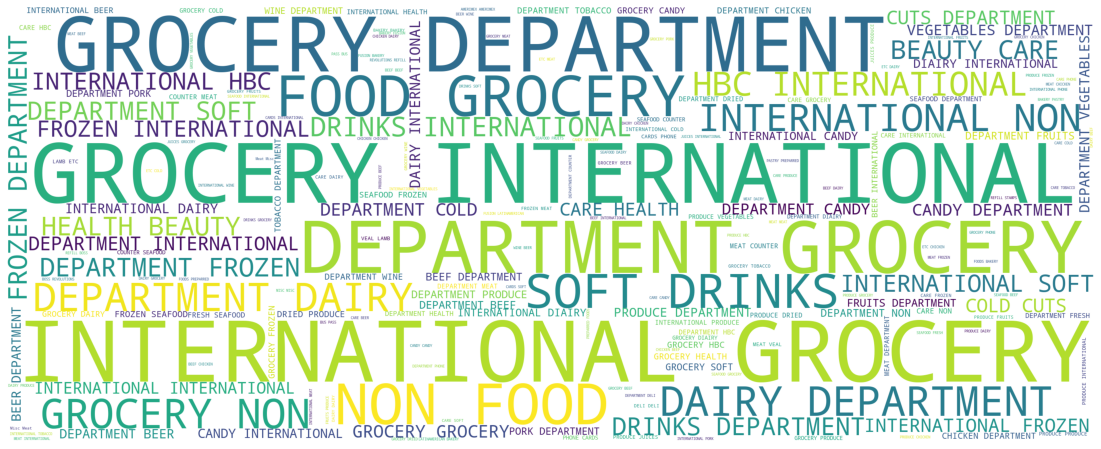

In [13]:
plt.subplots(figsize=(20,8))
wordcloud = WordCloud(background_color='White',width=2700,height=1080).generate(" ".join(df['SUB DPT']))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wc-sub-department.png')
plt.show()

### 2. Product DESCRIPTION

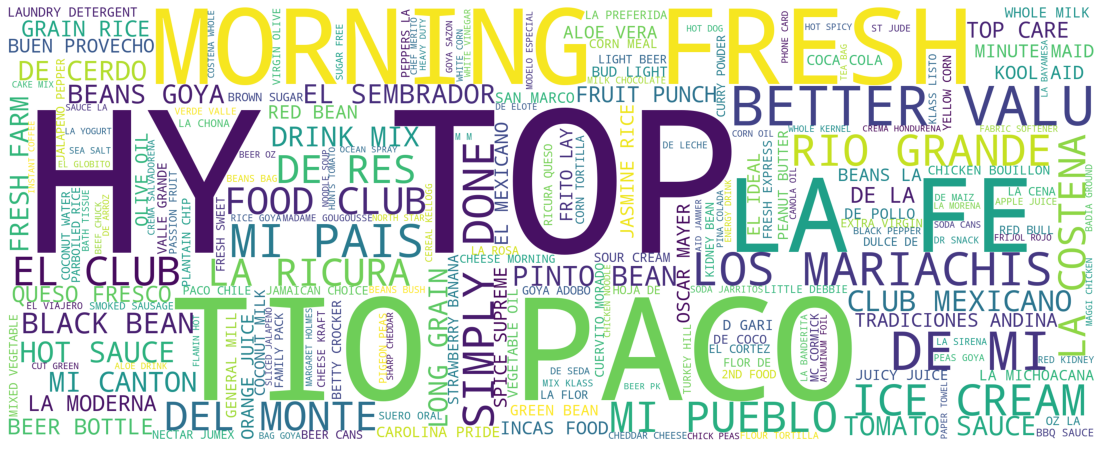

In [14]:
plt.subplots(figsize=(20,8))
df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)
wordcloud = WordCloud(background_color='White',width=2700,height=1080).generate(" ".join(df['DESCRIPTION']))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wc-description.png')
plt.show()

### 3. BRAND

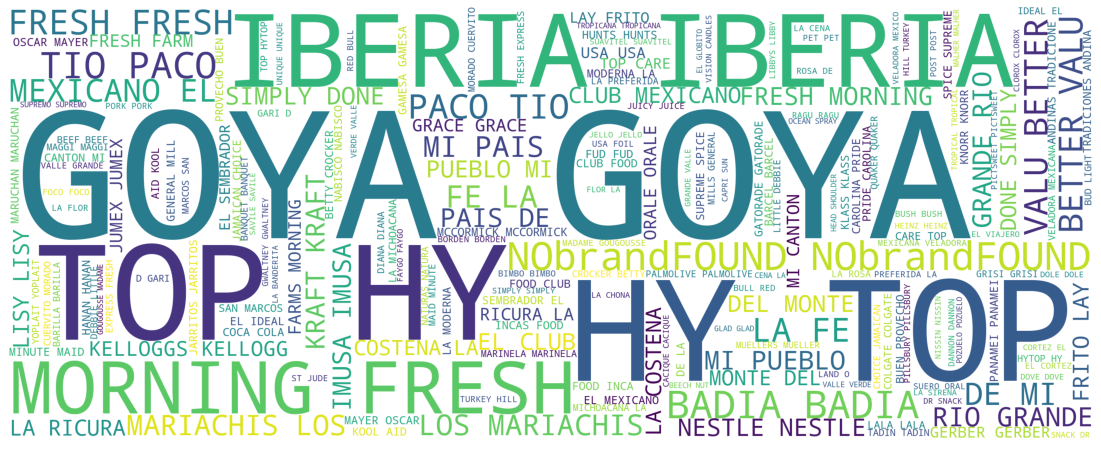

In [15]:
plt.subplots(figsize=(20,8))
df['BRAND'] = df['BRAND'].astype(str)
wordcloud = WordCloud(background_color='White',width=2700,height=1080).generate(" ".join(df['BRAND']))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wc-brand.png')
plt.show()

# 3. Time Series Sales Forecast

In [35]:
import fbprophet
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet.plot import plot
from matplotlib import pyplot
from matplotlib.pyplot import figure
from fbprophet.plot import add_changepoints_to_plot

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [36]:
#df = pd.read_csv('Data/comparefoods_combined.csv')
df['DATES']=pd.to_datetime(df['DATES'], format='%m/%d/%Y')
df['YEAR'] = df['DATES'].dt.year
df['MONTH'] = df['DATES'].dt.month
df['DATES'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.head()

,DATES,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT#,DEPT NAME,STORE NAME,STORE STATE,PRICE,YEAR,MONTH
0,2019-04-01,FRESH,FRESH BROCCOLI CROWNS,0.74000,1.84000,320.00000,VEGETABLES DEPARTMENT,4.00000,PRODUCE DEPT,FNIEVES,NC,2.48649,2019,4
1,2019-04-01,SWEET PAPAYA,SWEET PAPAYA,18.46000,23.82000,310.00000,FRUITS DEPARTMENT,4.00000,PRODUCE DEPT,FNIEVES,NC,1.29036,2019,4
2,2019-04-01,FRESH GREEN COOKING BANANAS,FRESH GREEN COOKING BANANAS,2.98000,2.35000,300.00000,PRODUCE DEPARTMENT,4.00000,PRODUCE DEPT,FNIEVES,NC,0.78859,2019,4
3,2019-04-01,FRESH YELLOW RIPE BANANAS,FRESH YELLOW RIPE BANANAS,17.78000,10.50000,300.00000,PRODUCE DEPARTMENT,4.00000,PRODUCE DEPT,FNIEVES,NC,0.59055,2019,4
4,2019-04-01,**NObrandFOUND**,APPLE RED DELICIOUS,2.18000,1.94000,310.00000,FRUITS DEPARTMENT,4.00000,PRODUCE DEPT,FNIEVES,NC,0.88991,2019,4


In [37]:
def trim_outliers(df):
    average = df['Total_Dollars_F65'].mean()
    std=df['Total_Dollars_F65'].std()
    outliers= (df['Total_Dollars_F65']-average).abs() > std
    df[outliers]=np.nan
    df['Total_Dollars_F65']=df['Total_Dollars_F65'].fillna(average)
    return df

def get_fb_forecasts(df, forecast_len):
    fb_df=df.reset_index().rename(columns={'DATES': 'ds', 'Total_Dollars_F65' : 'y'}).sort_values('ds', ascending=False)
    
    train=fb_df.head(len(fb_df)-forecast_len)
    
    #Train the model
    m = fbprophet.Prophet(weekly_seasonality=True)
    m.fit(train)
    
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    pd.plotting.register_matplotlib_converters()

    fig1 = plot(m, forecast, figsize=(15, 5))
    ax = fig1.gca()
    fig1.tight_layout()
    test= fb_df.tail(forecast_len)

    y_pred = forecast['yhat'].tail(forecast_len).values
    y_true = test['y'].values
    
    figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
    
    a = add_changepoints_to_plot(fig1.gca(),m , forecast)
    
    
    
    return y_pred, y_true

def validation_metrics(y_true, y_pred):
    smape = 100 * np.mean((np.abs(y_true - y_pred))/(np.abs(y_true) + np.abs(y_pred))/2)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#     pyplot.plot(y_true)
#     pyplot.plot(y_pred, color='g')
#     pyplot.show()
    
    return smape,rmse,mape
 

# 12m forecast for FNIEVES_df

### 1. Historical overview

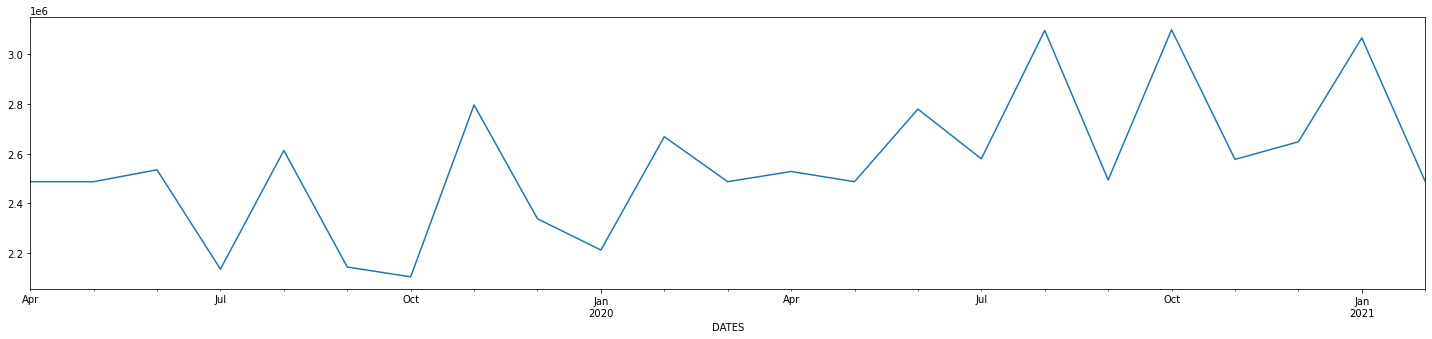

In [38]:
FNIEVES_df = df[df['STORE NAME']=='FNIEVES'].groupby('DATES').sum().drop(columns={'YEAR','MONTH','SUB DPT #','TotalUnits_F64'})
FNIEVES_df = trim_outliers(FNIEVES_df)
FNIEVES_df['Total_Dollars_F65'].plot(figsize=(25,5))

In [40]:
len(FNIEVES_df)

23

### 2. Forecasted charts

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


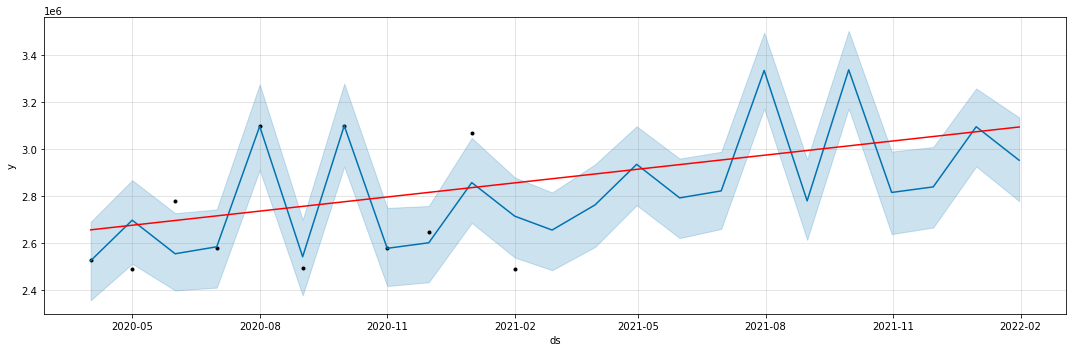

<Figure size 2000x480 with 0 Axes>

In [131]:
y_pred, y_true = get_fb_forecasts(FNIEVES_df,12)

### 3. Validations

In [132]:
smape,rmse,mape = validation_metrics(y_true, y_pred)
print('Test sMAPE: %.3f' % smape)
print('Test Accuracy:',  100-smape)

Test sMAPE: 4.789
Test Accuracy: 95.21122311894445


# 12m forecast for CFJSANCHEZ

### 1. Historical Overview

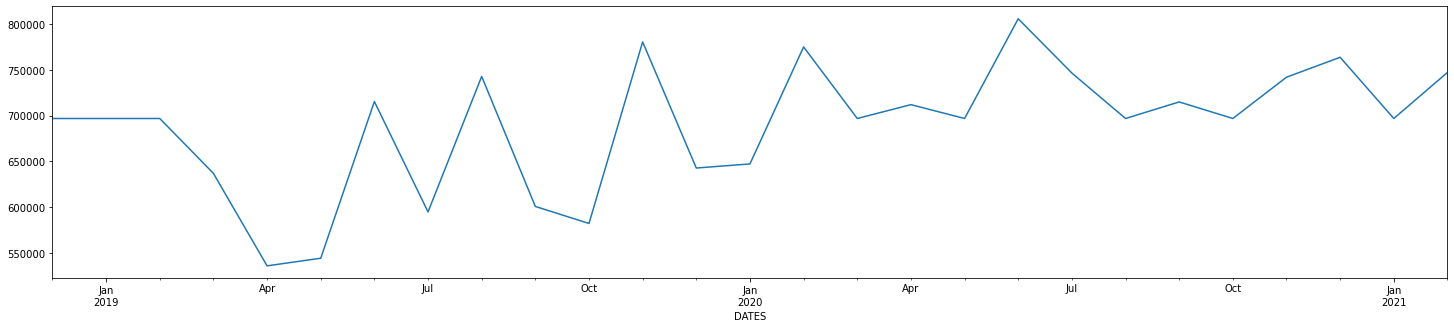

In [133]:
JSANCHEZ_df = df[df['STORE NAME']=='JSANCHEZ'].groupby('DATES').sum().drop(columns={'YEAR','MONTH','SUB DPT #','TotalUnits_F64'})
JSANCHEZ_df = trim_outliers(JSANCHEZ_df)
JSANCHEZ_df['Total_Dollars_F65'].plot(figsize=(25,5))

### 2. Forecasted charts

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


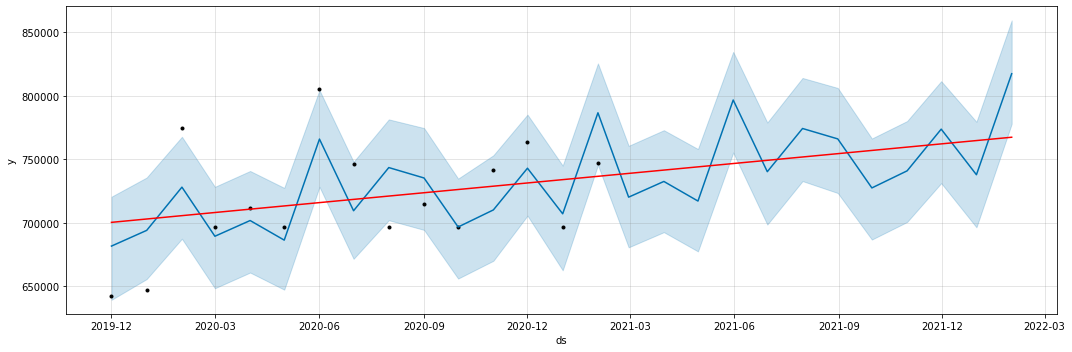

<Figure size 2000x480 with 0 Axes>

In [134]:
y_pred, y_true = get_fb_forecasts(JSANCHEZ_df,12)

In [135]:
smape,rmse,mape = validation_metrics(y_true, y_pred)
print('Test sMAPE: %.3f' % smape)
print('Test Accuracy:',  100-smape)

Test sMAPE: 4.093
Test Accuracy: 95.90707491374197


# 12m forecast for DPICHAR 

### 1. Historical Overview

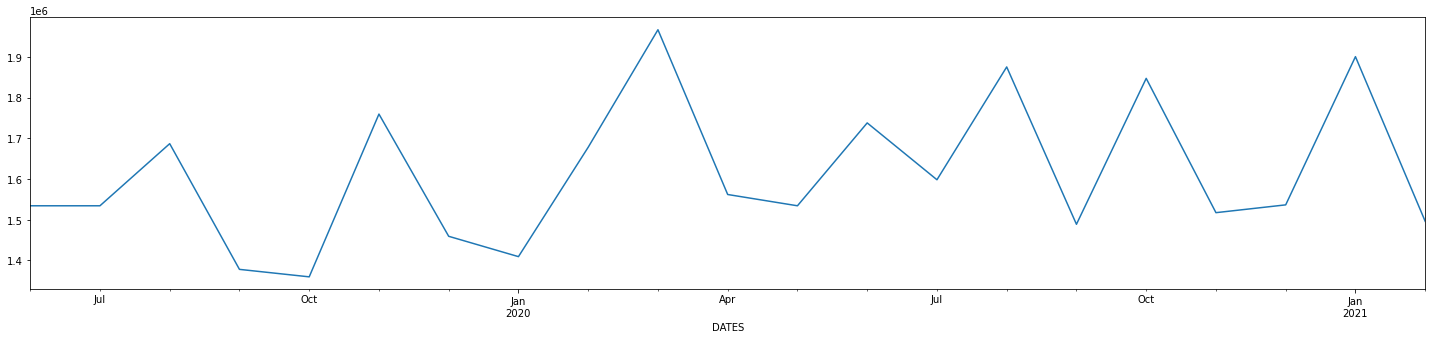

In [136]:
DPICHAR_df = df[df['STORE NAME']=='DPICHAR'].groupby('DATES').sum().drop(columns={'YEAR','MONTH','SUB DPT #','TotalUnits_F64'})
DPICHAR_df = trim_outliers(DPICHAR_df)
DPICHAR_df['Total_Dollars_F65'].plot(figsize=(25,5))

### 2. Forecasted charts

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


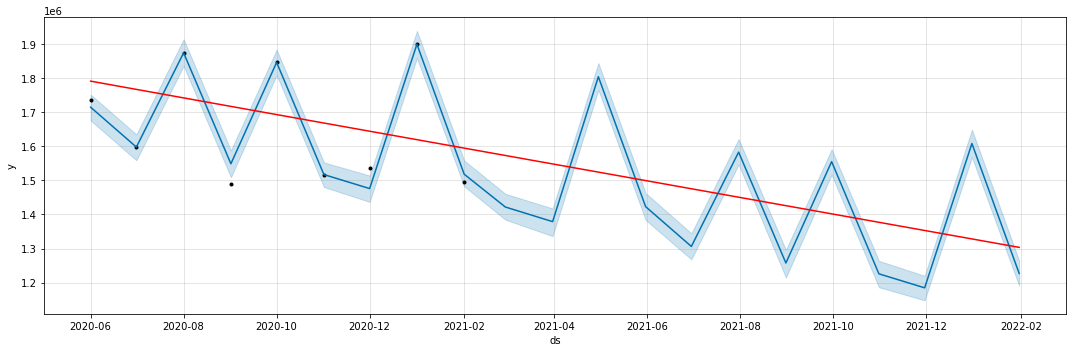

<Figure size 2000x480 with 0 Axes>

In [137]:
y_pred, y_true = get_fb_forecasts(DPICHAR_df,12)

### 3. Validations

In [138]:
smape,rmse,mape = validation_metrics(y_true, y_pred)
print('Test sMAPE: %.3f' % smape)
print('Test Accuracy:',  100-smape)

Test sMAPE: 3.775
Test Accuracy: 96.22507799449379


# 12m forecast for FPEREZ

### 1. Historical Overview

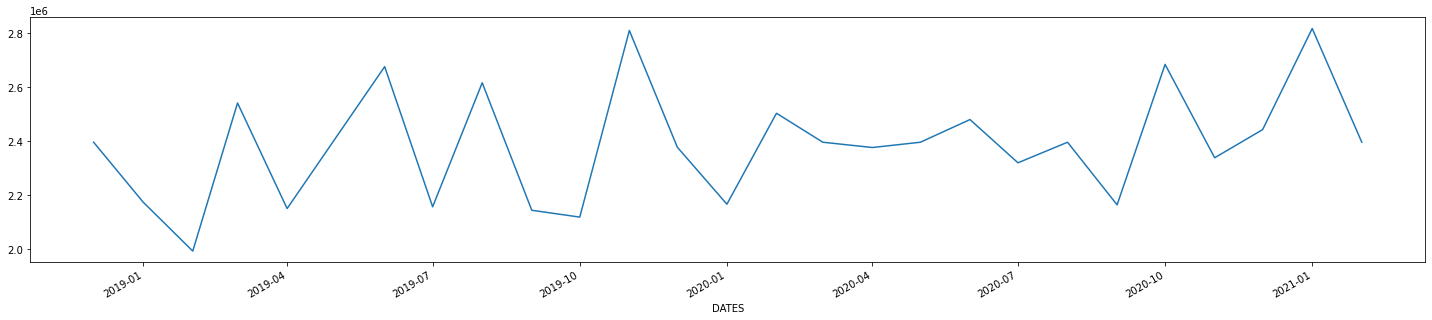

In [139]:
FPEREZ_df = df[df['STORE NAME']=='FPEREZ'].groupby('DATES').sum().drop(columns={'YEAR','MONTH','SUB DPT #','TotalUnits_F64'})
FPEREZ_df = trim_outliers(FPEREZ_df)
FPEREZ_df['Total_Dollars_F65'].plot(figsize=(25,5))

### 2. Forecasted charts

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


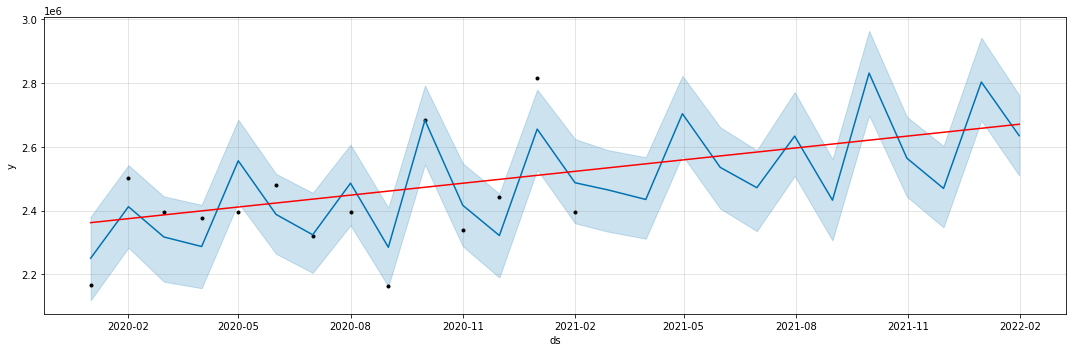

<Figure size 2000x480 with 0 Axes>

In [140]:
y_pred, y_true = get_fb_forecasts(FPEREZ_df,12)

### 3. Validations

In [141]:
smape,rmse,mape = validation_metrics(y_true, y_pred)
print('Test sMAPE: %.3f' % smape)
print('Test Accuracy:',  100-smape)

Test sMAPE: 3.715
Test Accuracy: 96.28548804206851
